# IEQ Data for Imputation
Code to get the relevant datasets to perform imputation on.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Exemplary Datasets to Use for Imputation Evaluation
Need I say more?

In [2]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import random
import missingno as msno

from scipy import stats
from sklearn.linear_model import LinearRegression

<a id='toc'></a>

# Table of Contents

1. [Data Import](#data_import)
2. [Remove at Random](#remove_random)
3. [Remove Periods at Random](#remove_periods_random)
4. [Save](#save)

---

<a id='data_import'></a>

[Back to ToC](#toc)
# Data Import
We will create the function to import a representative dataset using the beiwe id tag.

In [3]:
def import_example_data(pt,data_dir="../",params=["co2","pm2p5_mass","tvoc","temperature_c","co"]):
    """
    Imports example data
    
    Parameters
    ----------
    pt : str
        id of the participant to import for
    data_dir : str
        path to the "data" directory in the utx000 project
        
    Returns
    -------
    data : DataFrame
        exemplary ieq data from participant
    """
    
    try:
        data = pd.read_csv(f"{data_dir}data/interim/imputation/beacon-example-{pt}-ux_s20.csv",
                           index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
    except FileNotFoundError:
        print("No filename for participant", pt)
        return pd.DataFrame()
    
    return data[params]

In [4]:
data = import_example_data("rnse61g4")
data.head()

,co2,pm2p5_mass,tvoc,temperature_c,co
timestamp,,,,,
2020-06-11 13:52:00,1412.201879,22.713558,340.623409,24.037599,21.819001
2020-06-11 13:54:00,1411.594738,22.796582,343.521858,24.077255,21.523549
2020-06-11 13:56:00,1410.994147,22.721861,346.349039,24.113462,21.237295
2020-06-11 13:58:00,1410.628738,22.634113,349.113860,24.146652,20.965720
2020-06-11 14:00:00,1409.933588,22.695872,351.621536,24.177187,20.715069


[Back to Data Import](#data_import)

---

<a id='remove_random'></a>

[Back to ToC](#toc)
# Removing Data at Random

## Removing Observations from All Columns

In [5]:
def remove_at_random(df,percent=10):
    """
    Removes random rows from the dataset
    
    Parameters
    ----------
    df : DataFrame
        original data
    percent : int or float, default 10
        percent of data to remove
        
    Returns
    -------
    df_subset : DataFrame
        original data with rows removed
    """
    remove_n = int(percent/100*len(df))
    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    df_subset = df.drop(drop_indices)
    
    return df_subset

### Testing

In [6]:
data_subset = remove_at_random(data,20)
print(f"Length of original:\t{len(data)}\nLength of subset:\t{len(data_subset)}")

Length of original:	51127
Length of subset:	40902


## Removing Observations from Individual Columns
Rather than remove the entire row from the DataFrame, we consider each column separately. The process is:
* Determine the percent of missing data, `percent`
* Determine how many columns to consider, `n_col`
* For each column/param:
    * Remove `percent/n_col` percent of data from each column at random
    * Overwrite the data in the original DataFrame with the new data for that column only

In [7]:
def remove_at_random_all(df_in,percent=10,params=["co2","pm2p5_mass","tvoc","temperature_c"]):
    """
    Removes the given percentage of data individually across all parameters
    
    Parameters
    ----------
    df_in : DataFrame
        original data
    percent : int or float, default 10
        percent of data to remove
    params : list of str, default ["co2","pm2p5_mass","tvoc","temperature_c"]
        parameters to remove data from
        
    Returns
    -------
    df : DataFrame
        original data with observations removed
    """
    df = df_in.copy()
    true_percent = percent / len(params)
    for param in params:
        df_param = remove_at_random(df_in,percent=true_percent)
        df[param] = df_param[param]
        
    return df

### Testing

In [8]:
def check_missing(df):
    """
    Checks the missing data from the given df
    """
    print("Percent of Missing Data:",round(missing.isnull().sum().sum()/len(missing)*100,3))
    print("From each column:")
    for param in missing.columns:
        print(f"\t{param}:",round(missing[param].isnull().sum()/len(missing)*100,3))
    fig, ax = plt.subplots()
    msno.matrix(missing, ax=ax)
    plt.savefig("/Users/hagenfritz/Desktop/missing_at_random_all.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

Percent of Missing Data: 9.999
From each column:
	co2: 2.5
	pm2p5_mass: 2.5
	tvoc: 2.5
	temperature_c: 2.5
	co: 0.0


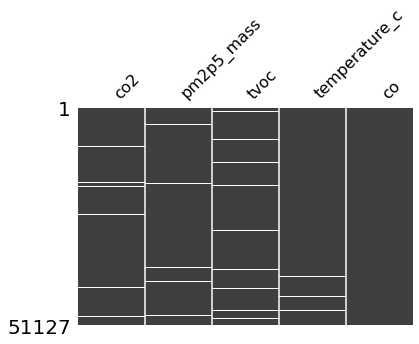

In [9]:
missing = remove_at_random_all(data)
check_missing(missing)

#### Removing percentage from select column

Percent of Missing Data: 29.998
From each column:
	co2: 19.999
	pm2p5_mass: 3.333
	tvoc: 3.333
	temperature_c: 3.333
	co: 0.0


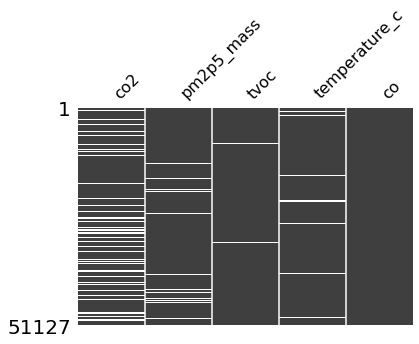

Percent of Missing Data: 29.998
From each column:
	co2: 0.0
	pm2p5_mass: 4.999
	tvoc: 19.999
	temperature_c: 4.999
	co: 0.0


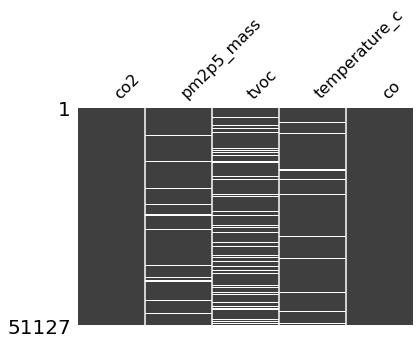

In [10]:
params=["co2","pm2p5_mass","tvoc","temperature_c"]
for param in params:
    grouped_params = params
    grouped_params.remove(param)
    some_missing = remove_at_random_all(data,percent=10,params=grouped_params)
    missing = remove_at_random_all(some_missing,percent=20,params=[param])
    check_missing(missing)

[Back to Pre-Processing](#pre_processing)

---

<a id='remove_periods_random'></a>

[Back to ToC](#toc)
# Remove Periods at Random
Rather than remove single data points, we can remove gaps of data from the dataframe.

See the question [here](https://stackoverflow.com/questions/69290810/remove-n-consecutive-non-overlapping-rows-at-random-from-pandas-dataframe-in-py) for more of an explanation of the function below:

## Remove Periods from One Parameter Only
All other parameters are untouched (remain complete) while we remove periods from one parameter. 

In [11]:
def remove_n_consecutive_rows_at_random(frame,n=5,percent=10):
    """
    Removes random periods of data from the dataset
    
    Parameters
    ----------
    frame : DataFrame
        original dataset
    n : int, default 5
        number of consecutive rows to remove in a single instance
    percent : int or float, default 10
        determines the number of instances to remove
        
    Return
    ------
    <subset> : DataFrame
        original dataframe with the missing data
    """
    chunks_to_remove = int(percent/100*frame.shape[0]/n)
    #split the indices into chunks of length n+2
    chunks = [list(range(i,i+n+2)) for i in range(0, frame.shape[0]-n)]
    drop_indices = list()
    for i in range(chunks_to_remove):
        indices = random.choice(chunks)
        drop_indices+=indices[1:-1]
        #remove all chunks which contain overlapping values with indices
        chunks = [c for c in chunks if not any(n in indices for n in c)]
    return frame.drop(drop_indices)

In [12]:
# Test
#data_subset = remove_n_consecutive_rows_at_random(data.reset_index(),n=5,percent=20)
#print(f"Length of original:\t{len(data)}\nLength of subset:\t{len(data_subset)}")

In [13]:
def get_n_consecutive_ixs(ixs,n=5,perc=10):
    """
    Gets n-consecutive indices at random (Kingsley)
    
    Parameters
    ----------
    ixs : list
        consecutive indices from DataFrame
    n : int, default 5
        number of consecutive rows to remove in a single instance
    percent : int or float, default 10
        determines the number of instances to remove
        
    Returns
    -------
    ixs : list
        new indices after removing consecutive values
    """
    ixs_count = len(ixs)*perc/100
    set_count = int(ixs_count/n)
    choice_ixs = [ix for ix in range(0,len(ixs)-(n+1),n)]
    choice_ixs = random.choices(choice_ixs,k=set_count)
    ixs_sets = [[ix + i for i in range(n)] for ix in choice_ixs]
    ixs = [ix for ixs in ixs_sets for ix in ixs]
    
    return ixs

## Remove Periods from One Parameter Only with Randomly Missing Data in Others
This represents a more realistic scenario where one sensor goes down and we still have spotty data from other sensors.

In [14]:
def remove_n_consecutive_with_other_missing(df_in,n,percent_all,percent_one,params,target):
    """
    Removes random periods of data from the dataset
    
    Parameters
    ----------
    df_in : DataFrame
        original dataset
    n : int
        number of consecutive rows to remove in a single instance
    percent : int or float
        determines the number of instances to remove
        
    Return
    ------
    <subset> : DataFrame
        original dataframe with the missing data
    """
    # remove data at random from all other columns
    df_missing = remove_at_random_all(df_in,percent=percent_all,params=params)
    
    # remove the consecutive observations 
    df = df_in.reset_index()
    drop_indices = get_n_consecutive_ixs(df.index,n=n,perc=percent_one)
    df_consecutive_missing = df.drop(drop_indices)
    
    # merge missing at random with missing observations for target and return
    comb = df_missing.drop(target,axis="columns").reset_index().merge(right=df_consecutive_missing[["timestamp",target]],on="timestamp",how="left")
    return comb

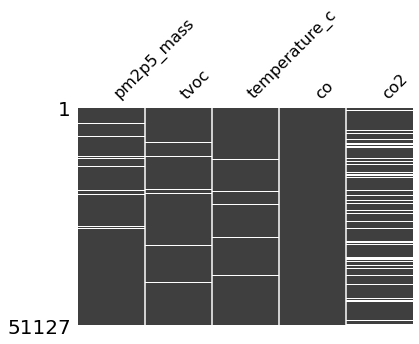

In [15]:
test = remove_n_consecutive_with_other_missing(data,60,10,20,["pm2p5_mass","tvoc","temperature_c"],"co2")
fig, ax = plt.subplots()
msno.matrix(test.drop("timestamp",axis="columns"), ax=ax)
plt.show()
plt.close()

[Back to Remove Periods at Random](#inspection)

---

<a id='inspection'></a>

[Back to ToC](#ToC)
# Inspection
Now that we have generated the random datasets, we want to make sure they actually follow what they say.

In [16]:
def plot_ts(df_test,df_original,sensor):
    """
    Plots the test set and the original to see the missing data
    """
    fig, ax = plt.subplots(figsize=(26,4))
    ax.scatter(df_test["timestamp"],df_test[sensor],s=5,color="cornflowerblue",label="Missing",zorder=100)
    ax.scatter(df_original.index,df_original[sensor],s=5,color="black",label="Original",zorder=10)
    
    ax.set_xlim([df_original.index[0],df_original.index[-1]])
    
    ax.legend()
    
    plt.show()
    plt.close()

In [17]:
# parameters
sensor = "tvoc"
consecutive_obs = 30
percent_missing = 10

## Missing at Random
First scheme test.

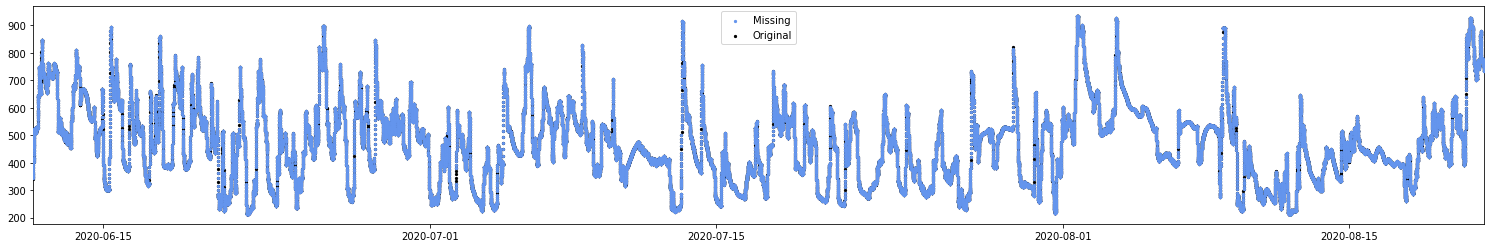

In [18]:
test_sensor = remove_at_random(data[[sensor]],percent=percent_missing)
test_comb = data.drop(sensor,axis="columns").merge(right=test_sensor,left_index=True,right_on="timestamp",how="outer")
plot_ts(test_comb,data,sensor)

<AxesSubplot:>

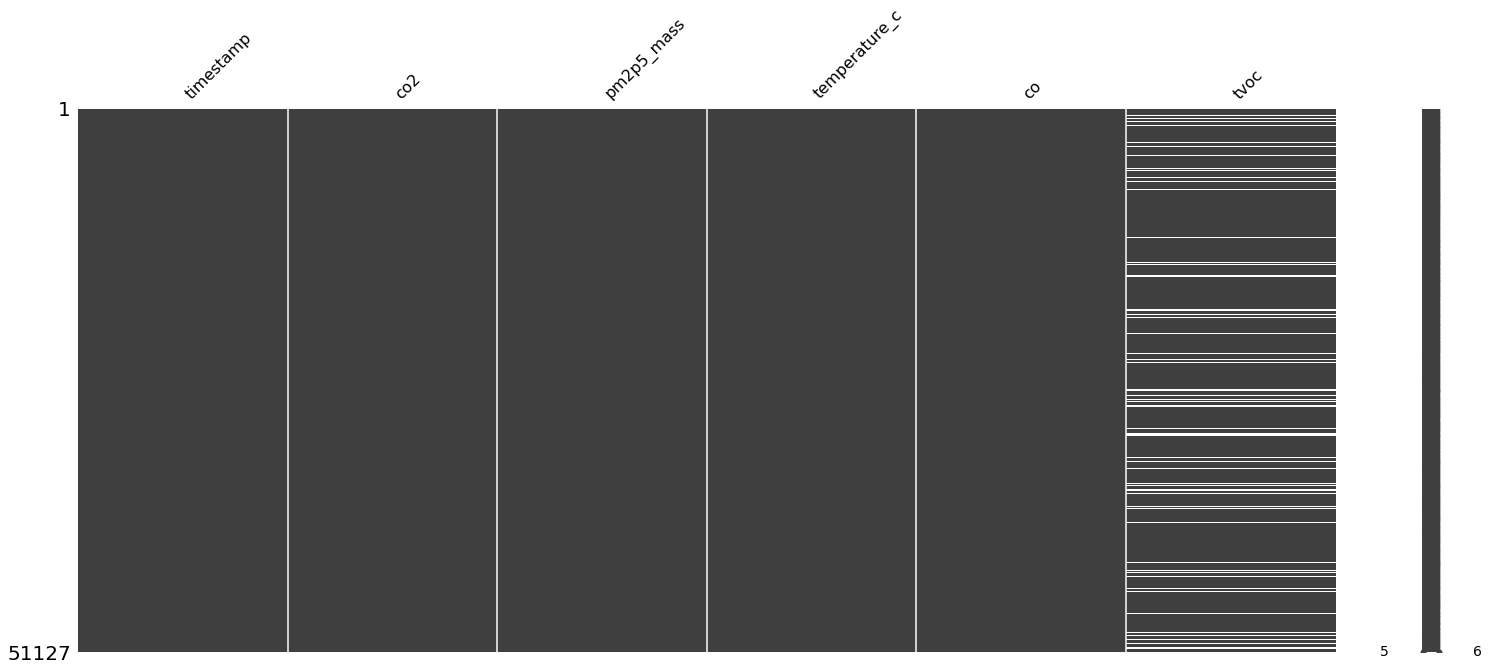

In [19]:
msno.matrix(test_comb)

In [20]:
print("Percent of Missing Data:", round(((1-len(test_sensor) / len(data)) * 100),2))

Percent of Missing Data: 10.0


## Missing Periods at Random
Second scheme test.

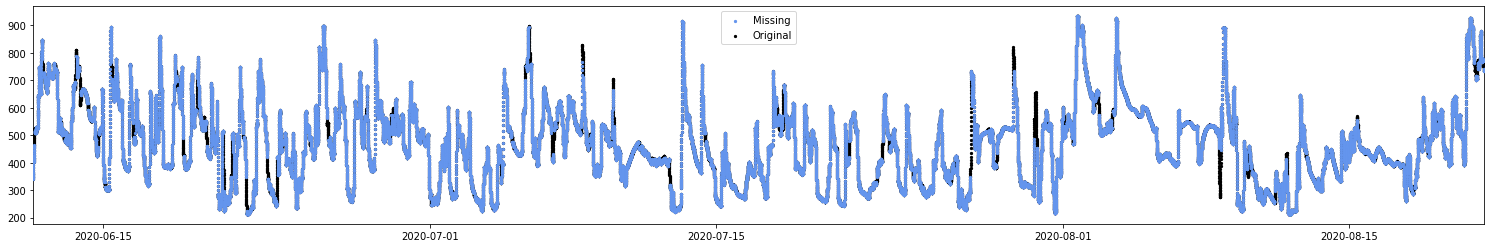

In [21]:
test_sensor = data[[sensor]].reset_index().drop(get_n_consecutive_ixs(data.index,consecutive_obs,percent_missing))
test_comb = data.drop(sensor,axis="columns").merge(right=test_sensor,left_index=True,right_on="timestamp",how="outer")
plot_ts(test_comb,data,sensor)

<AxesSubplot:>

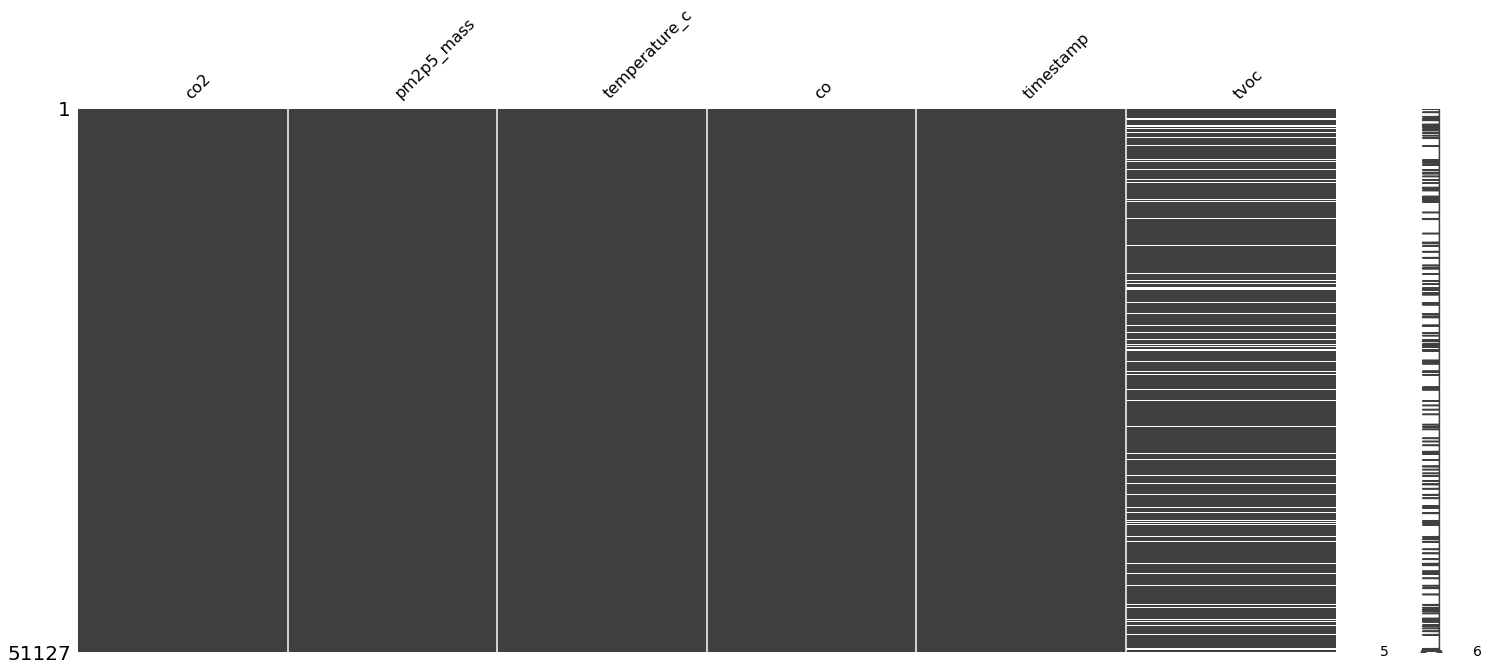

In [22]:
msno.matrix(test_comb)

In [23]:
print("Percent of Missing Data:", round(((1-len(test_sensor) / len(data)) * 100),2))

Percent of Missing Data: 9.27


[Back to Inspection](#inspection)

---

<a id='save'></a>

[Back to ToC](#toc)
# Save
To ensure the proper naming of the dataset when saving, we will create a pipeline in the following cells to re-runs the code above for each participant.

## Data Missing from One Parameter at a Time
In this scheme we only remove data from one IAQ parameter (column) at at time. We do this for:
* Missing at Random
* n-Consecutive Observations Missing at Random

In [24]:
#for pt in ["rnse61g4"]:#"xlw5ntd5"
#    data_pt = import_example_data(pt)
#    for sensor in ["co2","pm2p5_mass","tvoc","temperature_c","rh"]:
#        for p in [10,20,30]:
#            data_subset_random = remove_at_random(data_pt,p)
#            comb = data_pt.reset_index().drop(sensor,axis="columns").merge(right=data_subset_random[[sensor]],on=["timestamp"],how="left")
#            comb.to_csv(f"../data/interim/imputation/missing_data-{sensor}-random-p{p}-{pt}.csv")
#            for periods in [30,60]:
#                temp = data_pt[[sensor]].reset_index().drop(get_n_consecutive_ixs(data_pt.index,periods,p))
#                comb = data_pt.reset_index().drop(sensor,axis="columns").merge(right=temp,on="timestamp",how="left")
#                comb.to_csv(f"../data/interim/imputation/missing_data-random_periods-{sensor}-p{p}-{periods*2}mins-{pt}.csv",index=False)

## Data Missing from All Parameters
Now we remove data from the entire dataset.

In [26]:
params=["co2","pm2p5_mass","pm2p5_mass","tvoc","temperature_c","co"]
for pt in ["rnse61g4","xlw5ntd5","awa8uces"]:
    data_pt = import_example_data(pt)
    for param in params:
        grouped_params = params.copy()
        grouped_params.remove(param)
        for p in [5,10,15,20,25,30,35,40,45,50]:
            some_missing = remove_at_random_all(data,percent=10,params=grouped_params) # removing fixed number from all but one param
            missing_data = remove_at_random_all(some_missing,percent=p,params=[param]) # removing the given percentage from the select param
            missing_data.to_csv(f"../data/interim/imputation/missing_data-random_all-{param}-p{p}-{pt}.csv")

## Data Missing for Consecutive Observations per Parameter
Now we remove data from all the entire dataset and then drop consecutive observations from a certain parameter.

### General Performance

In [27]:
params = ["co2","pm2p5_mass","pm2p5_mass","tvoc","temperature_c","co"]
for pt in ["rnse61g4","xlw5ntd5","awa8uces"]:
    data_pt = import_example_data(pt)
    for p in [5,10,15,20,25,30,35,40,45,50]:
        for periods in [30,60,90,120]:
            for param in params:
                temp_list = params.copy()
                temp_list.remove(param)
                missing_data = remove_n_consecutive_with_other_missing(data_pt,periods,10,p,temp_list,param)
                missing_data.to_csv(f"../data/interim/imputation/missing_data-random_periods_all-{param}-p{p}-{periods*2}mins-{pt}.csv",index=False)

### Limit
We want to see what the maximum period of missing data we can have before we start to get negligible performance. This proces will help curate the analysis that we plan to do above. We fix the missing data from the given sensor to 10% and remove increasing more data at periods of an hour.

In [25]:
params = ["co2","pm2p5_mass","tvoc","temperature_c","co"]
for pt in ["rnse61g4"]:#,"xlw5ntd5","awa8uces"]:
    data_pt = import_example_data(pt)
    for periods in [30,60,90,120,150,180,210,240,270,300]:
        for param in params:
            temp_list = params.copy()
            temp_list.remove(param)
            missing_data = remove_n_consecutive_with_other_missing(data_pt,periods,10,10,temp_list,param)
            missing_data.to_csv(f"../data/interim/imputation/missing_data-random_periods_all-{param}-p10-{periods*2}mins-{pt}.csv",index=False)

<a id='effecs'></a>

[Back to Analysis](#analysis)

---

<a id='ieq_and_mood'></a>